In [1]:
import numpy as np
import matplotlib.pyplot as plt
from importlib import reload

import Detectors.Deep_Learning.AutoEncoders.utils
reload(Detectors.Deep_Learning.AutoEncoders.utils)
from Detectors.Deep_Learning.AutoEncoders.utils import SeqDataset,train_epoch,eval_data,train_model

# import flow.visualize.visualize_ring as visualize_ring
# reload(visualize_ring)
# from flow.visualize.visualize_ring import get_measured_leader,get_rel_dist_to_measured_leader,get_vel_of_measured_leader



import torch
# Anti-Flow specific functions for  detection:

from Detectors.Deep_Learning.AutoEncoders.utils import sliding_window
from Detectors.Deep_Learning.AutoEncoders.cnn_lstm_ae import CNNRecurrentAutoencoder

import utils
reload(utils)
from utils import Bando_OVM_FTL

import os

print('Libraries loaded.')


import Adversaries.controllers.car_following_adversarial
from Adversaries.controllers.car_following_adversarial import FollowerStopper_Overreact
from Adversaries.controllers.car_following_adversarial import ACC_Benign

1.7.1
Libraries loaded.


In [44]:
from flow.controllers.lane_change_controllers import AILaneChangeController


driver_controller_list_no_lc = []

sim_time = 1000
ring_length = 400


#cfm parameters:
a_mean=0.666
b_mean=21.6
s0_mean=2.21
s1_mean=2.82
Vm_mean=8.94

#lane-change parameters:

left_delta_mean = 0.5
right_delta_mean = 0.3
left_beta_mean=1.5
right_beta_mean=1.5
switching_threshold_mean = 5.0

num_human_drivers = 35

for i in range(num_human_drivers):
    a = a_mean + np.random.normal(0,0.1)
    b = b_mean + np.random.normal(0,0.5)
    s0 = s0_mean + np.random.normal(0,0.2)
    s1 = s1_mean + np.random.normal(0,0.2)
    Vm = Vm_mean + np.random.normal(0,0.5)
    
    left_delta = left_delta_mean + np.random.normal(0,0.1)
    right_delta = right_delta_mean + np.random.normal(0,0.1)
    left_beta = left_beta_mean + np.random.normal(0,0.2)
    right_beta = right_beta_mean + np.random.normal(0,0.2)
    switching_threshold = switching_threshold_mean + np.random.normal(0,0.3)

    label = 'bando_ftl_ovm_a'+str(np.round(a,2))+'_b'+str(np.round(b,2))+'_s0'+str(np.round(s0,2))+'_s1'+str(np.round(s1,2))+'_Vm'+str(np.round(Vm,2))
    cfm_controller = (Bando_OVM_FTL,{'a':a,'b':b,'s0':s0,'s1':s1,'Vm':Vm,'noise':0.1})
    
#     lc_controller = (AILaneChangeController,{'left_delta':left_delta,
#                                              'right_delta':right_delta,
#                                              left_beta:'left_beta',
#                                              right_beta:'right_beta',
#                                              switching_threshold:'switching_threshold'})
    
    driver_controller_list_no_lc.append([label,cfm_controller,1])
    
print('No lane changing.')

No lane changing.


In [2]:
from flow.controllers.lane_change_controllers import AILaneChangeController

driver_controller_list_with_lc = []

sim_time = 1000
ring_length = 600

#cfm parameters:
a_mean=0.666
b_mean=21.6
s0_mean=2.21
s1_mean=2.82
Vm_mean=8.94

#lane-change parameters:

left_delta_mean = 0.5
right_delta_mean = 0.3
left_beta_mean=1.5
right_beta_mean=1.5
switching_threshold_mean = 5.0

num_human_drivers = 35

for i in range(num_human_drivers):
    a = a_mean + np.random.normal(0,0.1)
    b = b_mean + np.random.normal(0,0.5)
    s0 = s0_mean + np.random.normal(0,0.2)
    s1 = s1_mean + np.random.normal(0,0.2)
    Vm = Vm_mean + np.random.normal(0,0.5)
    
    left_delta = left_delta_mean + np.random.normal(0,0.1)
    right_delta = right_delta_mean + np.random.normal(0,0.1)
    left_beta = left_beta_mean + np.random.normal(0,0.2)
    right_beta = right_beta_mean + np.random.normal(0,0.2)
    switching_threshold = switching_threshold_mean + np.random.normal(0,0.3)

    label = 'bando_ftl_ovm_a'+str(np.round(a,2))+'_b'+str(np.round(b,2))+'_s0'+str(np.round(s0,2))+'_s1'+str(np.round(s1,2))+'_Vm'+str(np.round(Vm,2))
    cfm_controller = (Bando_OVM_FTL,{'a':a,'b':b,'s0':s0,'s1':s1,'Vm':Vm,'noise':0.1})
    
    lc_controller = (AILaneChangeController,{'left_delta':left_delta,
                                             'right_delta':right_delta,
                                             'left_beta':left_beta,
                                             'right_beta':right_beta,
                                             'switching_threshold':switching_threshold})
    
    driver_controller_list_with_lc.append([label,cfm_controller,lc_controller,1])
    
print('With lane changing.')

With lane changing.


In [3]:
import flow
reload(flow)

#Import different needed quantities from Flow:
from flow.networks.ring import RingNetwork
from flow.core.params import VehicleParams
from flow.controllers.car_following_models import IDMController #Human driving model
from flow.controllers.routing_controllers import ContinuousRouter #Router that keeps vehicles on the ring-road

from flow.networks.ring import ADDITIONAL_NET_PARAMS
from flow.core.params import NetParams
from flow.core.params import InitialConfig
from flow.core.params import TrafficLightParams
from flow.envs.ring.accel import AccelEnv
from flow.envs.ring.accel import ADDITIONAL_ENV_PARAMS
from flow.core.params import SumoParams
from flow.core.params import EnvParams
from flow.core.params import SumoCarFollowingParams
from flow.core.experiment import Experiment

from sklearn.cluster import KMeans


# from Adversaries.controllers.car_following_adversarial import FollowerStopper_Overreact

from Adversaries.controllers.base_controller import BaseController


import os
import numpy as np

print('imported libraries for testing.')

imported libraries for testing.


In [47]:



def run_ring_sim_variable_cfm(ring_length=300,
    driver_controller_list=None,
    num_lanes=1,
    sim_time=500):

    #Simulation parameters:
    time_step = 0.1 #In seconds, how far each step of the simulation goes.
    emission_path = 'data' #Where csv is stored
    want_render = True #If we want SUMO to render the environment and display the simulation.
    sim_horizon = int(np.floor(sim_time/time_step)) #How many simulation steps will be taken -> Runs for 300 seconds

    #initialize the simulation using above parameters:
    traffic_lights = TrafficLightParams() #This is empty, so no traffic lights are used.
    initial_config = InitialConfig(shuffle=True,spacing="uniform", perturbation=1) #Vehicles start out evenly spaced.
    vehicles = VehicleParams() #The vehicles object will store different classes of drivers:
    sim_params = SumoParams(sim_step=time_step, render=want_render, emission_path=emission_path) #Sets the simulation time-step and where data will be recorded.
    env_params = EnvParams(additional_params=ADDITIONAL_ENV_PARAMS)
    net_params = NetParams(additional_params={'length':ring_length,
                                              'lanes':num_lanes,
                                              'speed_limit': 30,
                                              'resolution': 40})

    if(driver_controller_list is None):
        print('Running IDM.')
        num_human_drivers = 40
        #Default to the IDM if otherwise controllers not specified:
        vehicles.add("idm_driver",
            acceleration_controller=(IDMController, {'noise':0.1}),
            routing_controller=(ContinuousRouter, {}),
            car_following_params=SumoCarFollowingParams(speed_mode=0),
            num_vehicles=num_human_drivers)

    else:
        print('Number of classes of driver: '+str(len(driver_controller_list)))
        for driver in driver_controller_list:

            if(len(driver)==3):
                label = driver[0]
                cfm_controller = driver[1]
                num_vehicles = driver[2]

                vehicles.add(label,
                    acceleration_controller = cfm_controller,
                    routing_controller=(ContinuousRouter, {}),
                    car_following_params=SumoCarFollowingParams(speed_mode=0),
                    num_vehicles=num_vehicles)

            else:
                label = driver[0]
                cfm_controller = driver[1]
                lc_controller = driver[2]
                num_vehicles = driver[3]

                vehicles.add(label,
                    acceleration_controller = cfm_controller,
                    lane_change_controller = lc_controller,
                    routing_controller=(ContinuousRouter, {}),
                    car_following_params=SumoCarFollowingParams(speed_mode=0),
                    num_vehicles=num_vehicles)


    #initialize the simulation:
    flow_params = dict(
        exp_tag='ring_variable_cfm',
        env_name=AccelEnv,
        network=RingNetwork,
        simulator='traci',
        sim=sim_params,
        env=env_params,
        net=net_params,
        veh=vehicles,
        initial=initial_config,
        tls=traffic_lights,
    )

    flow_params['env'].horizon = sim_horizon
    exp = Experiment(flow_params)
    print('Running ring simulation, ring length: '+str(ring_length))
    
    sim_res_list = exp.run(1, convert_to_csv=True)
    
    return sim_res_list



sim_res_list_with_attack = run_ring_sim_variable_cfm(driver_controller_list = driver_controller_list_with_lc,
                                                     num_lanes=2,
                                                     sim_time=300)


Number of classes of driver: 35
Running ring simulation, ring length: 300


/opt/anaconda3/envs/anti_flow/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/anaconda3/envs/anti_flow/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Round 0, Return: 2570.684527658692
data/ring_variable_cfm_20220428-0833501651152830.826682-0_emission.csv data
Average, std velocities: 8.584035864649863, 0.0
Average, std outflows: 0.0, 0.0
Average, std avg_trip_energy: nan, nan
Average, std avg_trip_time: nan, nan
Average, std total_completed_trips: 0.0, 0.0
Average, std returns: 2570.684527658692, 0.0
Total time: 46.05195903778076
steps/second: 88.49087390389022


# Train a detector:

In [2]:
import numpy as np

import time

from Detectors.Deep_Learning.AutoEncoders.utils import SeqDataset,train_epoch,eval_data,train_model,get_cnn_lstm_ae_model,make_train_X,sliding_window_mult_feat

from Detectors.Deep_Learning.AutoEncoders.utils import get_loss_filter_indiv as loss_smooth

import flow.visualize.visualize_ring as visualize_ring

from flow.visualize.visualize_ring import get_measured_leader,get_rel_dist_to_measured_leader,get_vel_of_measured_leader

from copy import deepcopy

import sys


print('Imported detection tools.')

Imported detection tools.


In [3]:
reload(visualize_ring)

csv_path = '/Users/vanderbilt/Desktop/Research_2022/Anti-Flow/examples/data/ring_variable_cfm_20220420-1647381650491258.559167-0_emission.csv'

sim_timeseries_dict = visualize_ring.get_sim_timeseries(csv_path)

Data loaded.


bando_ftl_ovm_a0.69_b21.63_s02.22_s13.13_Vm10.83_0


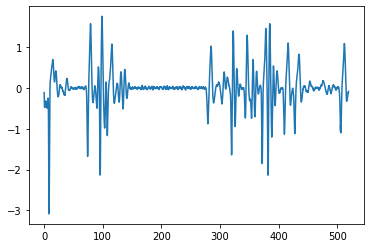

In [5]:
veh_ids = list(sim_timeseries_dict.keys())

veh_id = veh_ids[35]

print(veh_id)

time = sim_timeseries_dict[veh_id][:,0]

speed = sim_timeseries_dict[veh_id][:,1]

headway = sim_timeseries_dict[veh_id][:,2]

relative_speed = sim_timeseries_dict[veh_id][:,3]

plt.figure()
plt.plot(time,relative_speed)


In [10]:
import time

def train_ring_relative_detector(GPS_penetration_rate,ring_length,emission_path,n_epoch=200):

    warmup_period = 50 #Wait until there's a well developed wave

    timeseries_dict = visualize_ring.get_sim_timeseries(csv_path=emission_path,warmup_period=warmup_period)

    veh_ids = list(timeseries_dict.keys())

    num_measured_vehicle_ids = int(np.floor(len(veh_ids)*GPS_penetration_rate))
    measured_veh_ids = deepcopy(veh_ids)

    for i in range(len(measured_veh_ids)-num_measured_vehicle_ids):
        rand_int = np.random.randint(0,len(measured_veh_ids))
        del measured_veh_ids[rand_int]

    ring_sim_dict = visualize_ring.get_sim_data_dict_ring(csv_path=emission_path,warmup_period=warmup_period)

    timeseries_list = []

    for veh_id in measured_veh_ids:
        #[time,speed,headway,accel,leader_speed,fuel_consumption]
        speed = timeseries_dict[veh_id][:,1]
        accel = np.gradient(speed,.1)
        head_way = timeseries_dict[veh_id][:,2]
        rel_vel = timeseries_dict[veh_id][:,3]
        
        timeseries_list.append([speed,accel,head_way,rel_vel])

    train_X = make_train_X(timeseries_list)

    model = get_cnn_lstm_ae_model(n_features=4)

    model_file_name = 'ringlength'+str(ring_length)+'_2lanes_'+'_'+str(GPS_penetration_rate)+'percentGPS'

    print('Model: '+model_file_name)

    print('Beginning training...')
    begin_time = time.time()
    model = train_model(model,train_X,model_file_name,n_epoch=n_epoch)
    finish_time = time.time()
    print('Finished training, total time: '+str(finish_time-begin_time))

    return model


ring_length = 300
GPS_penetration_rate = 1.0
emission_path = csv_path

rel_info_AE_detector = train_ring_relative_detector(GPS_penetration_rate,
                                                    ring_length,
                                                    emission_path,
                                                    n_epoch=50)


Data loaded.
Data loaded.
Model: ringlength600_1.0percentGPS
Beginning training...
Creating new model.
Epoch 0, total loss 186225.533463, total predictions 4000, avg loss 46.556383 2022-04-26 10:00:29.493400
Saving model. Best loss: 46.556383365631106
Saving model. Best loss: 46.44219161987305
Saving model. Best loss: 44.97365065383911
Saving model. Best loss: 43.6309055595398
Epoch 5, total loss 147345.799408, total predictions 4000, avg loss 36.836450 2022-04-26 10:01:52.154528
Saving model. Best loss: 36.83644985198975
Saving model. Best loss: 31.506930397033692
Saving model. Best loss: 27.42169248199463
Saving model. Best loss: 21.88843008995056
Epoch 10, total loss 82046.580589, total predictions 4000, avg loss 20.511645 2022-04-26 10:03:19.248846
Saving model. Best loss: 20.51164514732361
Saving model. Best loss: 20.240956119537355
Saving model. Best loss: 19.35211772823334
Epoch 15, total loss 90812.246796, total predictions 4000, avg loss 22.703062 2022-04-26 10:04:45.115863
Sa

In [21]:
attacked_csv_path = '/Users/vanderbilt/Desktop/Research_2022/Anti-Flow/examples/data/ring_variable_cfm_with_attacl_20220426-1015511650986151.50053-0_emission.csv'

sim_timeseries_dict_with_attack = visualize_ring.get_sim_timeseries(attacked_csv_path)

Data loaded.


In [23]:
veh_ids_no_attacks = list(sim_timeseries_dict_no_attack.keys())

veh_ids_with_attacks = list(sim_timeseries_dict_with_attack.keys())

speeds_with_attack_by_time = []

speeds_no_attack_by_time = []

for veh_id in veh_ids_no_attacks:
    
        speed = sim_timeseries_dict_no_attack[veh_id][:,1]
        
        speeds_no_attack_by_time.append(speed)
        
        
for veh_id in veh_ids_with_attacks:
    
        speed = sim_timeseries_dict_with_attack[veh_id][:,1]
        
        speeds_with_attack_by_time.append(speed)
        

        
print('Speeds extracted.')

Speeds extracted.


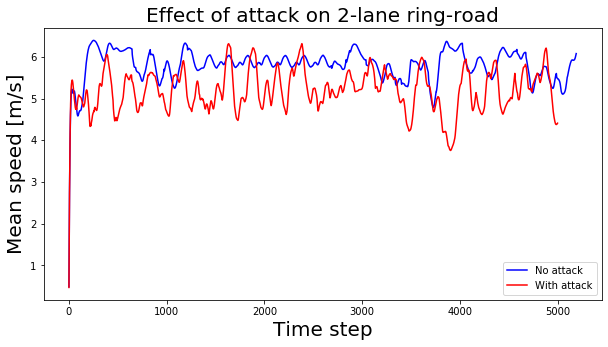

In [26]:
speeds_with_attack_by_time = np.array(speeds_with_attack_by_time)

speeds_no_attack_by_time = np.array(speeds_no_attack_by_time)

plt.figure(figsize=[10,5])

plt.plot(np.mean(speeds_no_attack_by_time,axis=0),'b',label='No attack')

plt.plot(np.mean(speeds_with_attack_by_time,axis=0),'r',label='With attack')

plt.ylabel('Mean speed [m/s]',fontsize=20)
plt.xlabel('Time step',fontsize=20)
plt.title('Effect of attack on 2-lane ring-road',fontsize=20)

plt.legend()

# Compare loss values from the detector trained in the benign environment:

Vehicles processed: 40

Vehicles processed: 40

Losses found.


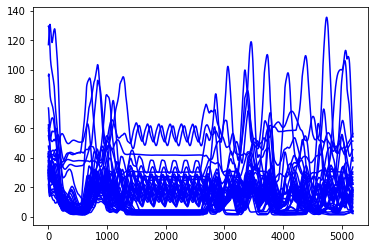

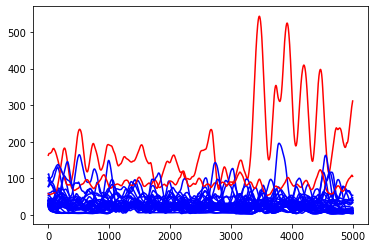

In [34]:
reload(Detectors.Deep_Learning.AutoEncoders.utils)
reload(utils)
from utils import assess_relative_model_on_attack
import time


#This is custom for total observation:

def get_losses(timeseries_dict,model,want_timeseries_plot=True):
    veh_ids = list(timeseries_dict.keys())
   
    num_veh_processed = 0

    testing_losses_dict = dict.fromkeys(veh_ids)

    for veh_id in veh_ids:
        timeseries_list = []
        
        speed = timeseries_dict[veh_id][:,1]
        accel = np.gradient(speed,.1)
        head_way = timeseries_dict[veh_id][:,2]
        rel_vel = timeseries_dict[veh_id][:,3]
        
        timeseries_list.append([speed,accel,head_way,rel_vel])

        timeseries_list = [speed,accel,head_way,rel_vel]

        _,loss = sliding_window_mult_feat(model,timeseries_list)

        testing_losses_dict[veh_id]=loss

        num_veh_processed+=1

        sys.stdout.write('\r'+'Vehicles processed: '+str(num_veh_processed)+'\r')

    print('\n')
    
    smoothed_losses = dict.fromkeys(veh_ids)
    time = timeseries_dict[veh_ids[0]][:,0]
    
    #Get smoothed loss values:
    for veh_id in veh_ids:
        loss = testing_losses_dict[veh_id]
        smoothed_loss = loss_smooth(time,loss)
            
        smoothed_losses[veh_id] =  loss_smooth(time,loss)

    
    if(want_timeseries_plot):
        plt.figure()
        
        for veh_id in veh_ids:
            smoothed_loss = smoothed_losses[veh_id]
            if('FStop' in veh_id):
                plt.plot(smoothed_loss,'r')
            else:
                plt.plot(smoothed_loss,'b')
        
    return smoothed_losses



model = rel_info_AE_detector

losses_no_attack = get_losses(sim_timeseries_dict_no_attack,model)

losses_with_attack = get_losses(sim_timeseries_dict_with_attack,model)

print('Losses found.')


Text(0, 0.5, 'Max loss')

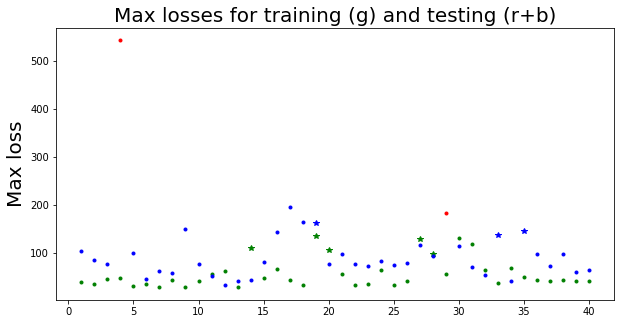

In [51]:
plt.figure(figsize=[10,5])


tmp = 1

for veh_id in veh_ids_no_attacks:
    max_loss = np.max(losses_no_attack[veh_id])
    
    if('ACC' in veh_id):
        plt.plot(tmp,max_loss,'g*')
        tmp += 1
        
    else:
        plt.plot(tmp,max_loss,'g.')
        tmp += 1        
    
tmp = 1
for veh_id in veh_ids_with_attacks:
    max_loss = np.max(losses_with_attack[veh_id])
    
    if('FStop' in veh_id):
        plt.plot(tmp,max_loss,'r.')
        tmp += 1
    else:
        if('ACC' in veh_id):
            plt.plot(tmp,max_loss,'b*')
            tmp += 1
        else:
            plt.plot(tmp,max_loss,'b.')
            tmp += 1

plt.title('Max losses for training (g) and testing (r+b)',fontsize=20)
plt.ylabel('Max loss',fontsize=20)


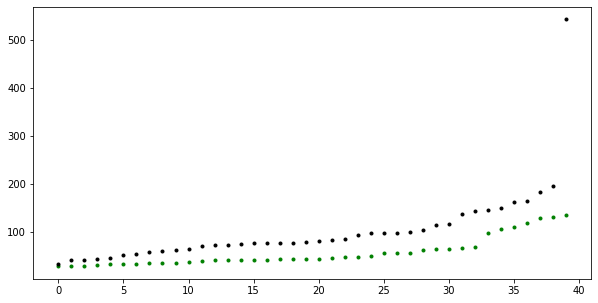

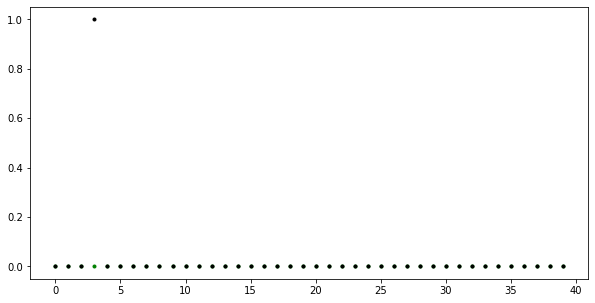

In [65]:
from sklearn.cluster import KMeans


def k_means_cluster(max_losses,cluster_diff=0.1):

    min_l = np.min(max_losses)
    max_l = np.max(max_losses)
    normalize_losses = (max_losses-min_l)/(max_l-min_l)
    X = normalize_losses
    kmeans = KMeans(n_clusters=2, random_state=0).fit(X.reshape(-1,1))
    labels = kmeans.labels_
    cluster_centroids = kmeans.cluster_centers_

    positive_labels = []
    negative_labels = []

    for i in range(len(X)):
        l = X[i]
        label = labels[i]
        if(label==0):negative_labels.append(l)
        else:positive_labels.append(l) 

    if(np.min(positive_labels)-cluster_diff > np.max(negative_labels)):
        return labels,cluster_centroids
    else:
        return np.zeros_like(labels),None
    
    
plt.figure(figsize=[10,5])
    
no_attack_max_losses = []
for veh_id in veh_ids_no_attacks:
    max_loss = np.max(losses_no_attack[veh_id])
    no_attack_max_losses.append(max_loss)

plt.plot(np.sort(no_attack_max_losses),'g.')
    
with_attack_max_losses = []
for veh_id in veh_ids_with_attacks:
    max_loss = np.max(losses_with_attack[veh_id])
    with_attack_max_losses.append(max_loss)
    
plt.plot(np.sort(with_attack_max_losses),'k.')
    
cluster_diff = 0.3

no_attack_labels,centroids_no_attack = k_means_cluster(no_attack_max_losses,cluster_diff=cluster_diff)

with_attack_labels,centroids_no_attack = k_means_cluster(with_attack_max_losses,cluster_diff=cluster_diff)
    
plt.figure(figsize=[10,5])    
plt.plot(no_attack_labels,'g.')
plt.plot(with_attack_labels,'k.')

In [57]:
from sklearn.metrics import auc

print(auc(no_attack_max_losses,))